In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#%% Prepare dataset

# Load dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

# Model / data parameters
num_classes = len(np.unique(y_train))
input_shape = x_train.shape[1::]

In [3]:
#%% Create model

inputs = tf.keras.Input(shape=input_shape)

def ResidualModule(inputs, filters):
    conv_1 = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='relu')(inputs)
    conv_2 = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same', activation='linear')(conv_1)
    temp = tf.add(inputs, conv_2)
    outputs = tf.nn.relu(temp)
    
    return outputs


# Initial layers
x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

# Residual 1
x = ResidualModule(x, 32)
x = ResidualModule(x, 32)
x = ResidualModule(x, 32)

# Residual 2
x = tf.keras.layers.Conv2D(80, kernel_size=(3, 3), strides=(2, 2), padding='same')(x)
x = ResidualModule(x, 80)
x = ResidualModule(x, 80)
x = ResidualModule(x, 80)

# Output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name="resnet")
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

print(model.summary())


Model: "resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   9248        max_pooling2d[0][0]              
_____________________________________________________________________________________________

In [4]:
#%% Train model

batch_size = 256
epochs = 50

earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

history = model.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    callbacks=[earlystop],
                    use_multiprocessing=True,
                    validation_data=(x_test, y_test))

Epoch 1/50
196/196 [==============================] - 16s 49ms/step - loss: 7.5931 - accuracy: 0.0149 - val_loss: 4.5028 - val_accuracy: 0.0236
Epoch 2/50
196/196 [==============================] - 9s 44ms/step - loss: 4.3501 - accuracy: 0.0408 - val_loss: 4.0310 - val_accuracy: 0.0816
Epoch 3/50
196/196 [==============================] - 9s 44ms/step - loss: 3.9496 - accuracy: 0.0945 - val_loss: 3.7303 - val_accuracy: 0.1367
Epoch 4/50
196/196 [==============================] - 9s 44ms/step - loss: 3.7057 - accuracy: 0.1336 - val_loss: 3.5142 - val_accuracy: 0.1719
Epoch 5/50
196/196 [==============================] - 9s 45ms/step - loss: 3.5284 - accuracy: 0.1648 - val_loss: 3.4339 - val_accuracy: 0.1945
Epoch 6/50
196/196 [==============================] - 9s 45ms/step - loss: 3.3711 - accuracy: 0.1942 - val_loss: 3.3406 - val_accuracy: 0.2093
Epoch 7/50
196/196 [==============================] - 9s 46ms/step - loss: 3.2552 - accuracy: 0.2151 - val_loss: 3.2073 - val_accuracy: 0.231

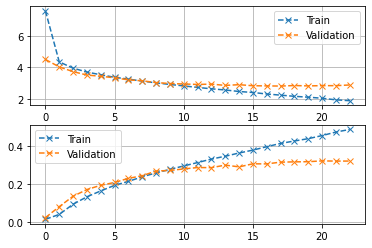

In [5]:
#%% Model visualization
plt.figure()
plt.subplot(2, 1, 1)
plt.grid()
plt.plot(history.history['loss'], '--x')
plt.plot(history.history['val_loss'], '--x')
plt.legend(['Train', 'Validation'])
plt.subplot(2, 1, 2)
plt.grid()
plt.plot(history.history['accuracy'], '--x')
plt.plot(history.history['val_accuracy'], '--x')
plt.legend(['Train', 'Validation'])

In [6]:
#%% Model evaluation
result = model.evaluate(x_test, y_test)
print("Test accuracy: {:.2f}%".format(result[1]*100))

313/313 [==============================] - 2s 5ms/step - loss: 2.8130 - accuracy: 0.3165
Test accuracy: 31.65%
